# Exercise 7: Explainable Methods

In this exercise, you will explore some of the explainable methods that you have learned in the lecture using concrete models and examples from two different modalities: text and images. The focus of this exercise is on the analysis of the explanations, models, and input data. Therefore, you do not need to implement much but instead change hyperparameters and input variables to explore the capabilities and limits of the techniques.

We will use the XAI implementations of [Pytorch's captum library](https://captum.ai/api/) which contains several methods that you have seen in the lecture. This is not the only source of good XAI implementations but as part of the Pytorch universe, it is compatible with other Pytorch libraries that we will use (torch, torchtext, torchvision), and will probably be maintained and extended with more techniques in the future. Check out [this summary](https://captum.ai/docs/attribution_algorithms) if you want to see which explanation methods are implemented in this framework.

**Note I:** If you have the problem of running out of memory, try restarting the kernel between Task 1 and 2. If the problem remains, reduce hyperparameters like n_steps or n_samples but be aware that your results and findings can be affected by it. If you do this, please state it in your answers.

**Note II:** The exercise is designed such that all steps are executable on CPU in reasonable time. Using a GPU would speed everything up, so if you prefer, you can of course adapt the code to run it on GPU. If you do this, please indicate this in your answers. If you do not state anything, we will assume that you run everything on CPU.


#### Your tasks in this exercise:
* Analyze two neural networks using different explainers (i.e. explanation methods)
* Test how the explanations differ depending on settings and input
* Relate your observations to the contents of the lecture and analyze them critically

## Setup
Before you start, make sure that you have created a virtual environment with Python >= 3.8, and have installed the dependencies given below. 

#### Requirements:
```
numpy
spacy
torch
torchvision
matplotlib
captum
```
(The versions of these libraries might depend on your version of Python. As a point of reference, the code has been tested with the following versions: Python==3.10.10, numpy==1.23.4, spacy==3.5.3, torch==2.0.0, torchvision==0.15.1, matplotlib==3.6.2, captum==0.6.0)

Once you have created the environment, run this command on the command line:
```
python -m spacy download en_core_web_sm
```
This will install the language model that we need for preprocessing the text input.


## Import packages

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
# import spacy
import json
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.models import resnet18
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image

from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt

# Import the explanation methods we are going to use in this exercise
from captum.attr import (LayerIntegratedGradients,
                        LayerDeepLift,
                        LayerActivation,
                        Lime,
                        KernelShap,
                        IntegratedGradients)
# Import some helper functions for the explainers
from captum.attr import (TokenReferenceBase,  # to create reference inputs
                         NoiseTunnel,  # to run explainers on noisy copies of the input
                         LayerAttribution,  # to scale attribution maps to input size
                         configure_interpretable_embedding_layer,  # to make embeddings interpretable
                         remove_interpretable_embedding_layer,  # to revert embeddings to non-interpretable default
                         visualization)  # to visualize explanations
from captum._utils.models.linear_model.model import SkLearnLasso

print(torch.__version__)

2.0.1


## Task 1: Analyzing an NLP model

In this task, we will look at a classical NLP classification task that is often used in XAI: Sentiment analysis. Our model has been trained to predict whether a text displays a positive sentiment or a negative one, making it a binary decision. The model itself is a CNN that takes [GloVe word embeddings](https://nlp.stanford.edu/projects/glove/) as input and outputs a scalar prediction value. If that value is < 0.5, the predicted sentiment is *negative* (0), otherwise *positive* (1). 

The code and models in this task are taken from [this tutorial](https://captum.ai/tutorials/IMDB_TorchText_Interpret). Before you run the code, download the model [imdb-model-cnn-large.pt](https://github.com/pytorch/captum/blob/master/tutorials/models/imdb-model-cnn-large.pt). The vocabulary and matching GLoVe indices are already prepared in vocab.json.

Now, run the following five code cells and answer the questions at the end of the task.

In [2]:
# The sentiment classification model
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx):
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.embedding(text) # [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1) # [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs] # [batch size, n_filters, sent len - filter_sizes[n] + 1]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved] #[batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1)) # [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)
    
# Load the model
model = torch.load('imdb-model-cnn-large.pt')
model.eval()
    
def forward_with_sigmoid(inp):
    return torch.sigmoid(model(inp))

In [3]:
class Preprocessing:
    
    def __init__(self, vocab_path):
        self.nlp = spacy.load('en_core_web_sm')
        
        self.vocab = defaultdict(lambda: 0)
        with open(vocab_path, 'r') as f:
            self.vocab.update(json.load(f))
            
        self.pad_token = '<pad>'
        self.pad_ind = self.vocab[self.pad_token]
        
    def __len__(self):
        return len(self.vocab)
    
    # This preprocesses the input and returns the tokenized sentence (text) as well as the encoded one (input_indices)
    def prepare_sentence(self, sentence, min_len=7):
        text = [tok.text for tok in self.nlp.tokenizer(sentence.lower())]
        if len(text) < min_len:
            text += [self.pad_token] * (min_len - len(text))
        indexed = [self.vocab[t] for t in text]

        input_indices = torch.tensor(indexed)
        input_indices = input_indices.unsqueeze(0)

        return text, input_indices

preprocess = Preprocessing(vocab_path='vocab.json')

In [4]:
classes = {0: 'neg', 1: 'pos'}

# Once we get the attributions ("explanations") for a sentence from an explainer, we will store it in a specific 
# DataRecord object that will help us to visualize the explanation
def add_attributions_to_visualizer(attributions, text, pred, pred_ind, label):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()
    
    return visualization.VisualizationDataRecord(
                            attributions,
                            pred,
                            classes[pred_ind],
                            classes[label],
                            classes[1],
                            attributions.sum(),
                            text,
                            None)

We are going to test five different explainers: [Layer Activation](https://captum.ai/api/layer.html#layer-activation), [Layer Integrated Gradients](https://captum.ai/api/layer.html#layer-integrated-gradients), [Layer DeepLIFT](https://captum.ai/api/layer.html#layer-deeplift), [LIME](https://captum.ai/api/lime.html), and [KernelShap](https://captum.ai/api/kernel_shap.html). 

**Layer Integrated Gradients** and **Layer DeepLIFT** are variants of the methods *Integrated Gradients* and *DeepLIFT* which have been described in the lecture. The *Layer* modifier just indicates that instead of computing the influence of the *input* on the output prediction, we compute it for the nodes of a specific *layer*. This makes sense if our network first performs a feature extraction on some raw input, and we care more about the meaning of each feature. In our case, we will use the layer variants for the *embedding* layer because this allows us to skip an unnecessary step: Since the transformation process from input to embeddings is fairly linear (one token corresponds to one embedding), we do not need to explain this step, and can directly start with the embeddings as input. Also, it is very simple to project the explanations that we get for our embeddings back to our input tokens (since it is a 1:1 projection).

**Layer Activation** is a very simple method which we have not covered in the lecture. It simply outputs the activation values of a specific layer as computed during the forward pass of the input sample. We can project the nodes back to the input to get a score of how much the input feature led to activation in the layer, which, depending on the network, can give us an estimate for the activation in the overall model. Again, we will use the *embedding* layer for this method.

**LIME** and **KernelShap** are used as described in the lecture. They are model-agnostic and work on input perturbation, thus, we are not starting at a layer inside the model but use the whole model for generating the explanations. However, specific to the captum library and its internal processing, we need to wrap the embeddings layer into an interpretable embeddings layer (and later remove this wrapping again). You do not need to worry about this unless, for some reason, there is an error raised within the explain_with_Lime or explain_with_KernelShap methods and the layer could not be removed again. If this happens, it is easiest to simply reload the model with `model = torch.load('imdb-model-cnn-large.pt')` to reset the model.

In [5]:
# For several explainers, we need a reference input as a baseline. Usually, this is just a zero or random vector, 
# but we can just create a reference input based on the vector corresponding to the padding token
token_reference = TokenReferenceBase(reference_token_idx=preprocess.pad_ind)


# We are going to apply several explainers to the model to examine the similarities and differences between them

# 1. LayerIntegratedGradients
def explain_with_LayerIntegratedGradients(sentences, min_len=7):
    vis_data_records = []
    lig = LayerIntegratedGradients(model, model.embedding)

    for sentence, label in sentences:
        model.zero_grad()
        text, input_indices = preprocess.prepare_sentence(sentence, min_len)

        # Predict
        pred = forward_with_sigmoid(input_indices).item()
        pred_ind = round(pred)

        # Generate reference indices for each sample
        reference_indices = token_reference.generate_reference(min_len, device='cpu').unsqueeze(0)

        # Compute attributions
        attributions = lig.attribute(input_indices, reference_indices, n_steps=15)
        
        vis_data_records.append(add_attributions_to_visualizer(attributions, text, pred, pred_ind, label))
        
    print('Visualize attributions based on Layer Integrated Gradients:')
    _ = visualization.visualize_text(vis_data_records)
    print('-'*50)
    
    
# 2. LayerDeepLift
def explain_with_LayerDeepLift(sentences, min_len=7):
    vis_data_records = []
    ldl = LayerDeepLift(model, model.embedding)

    for sentence, label in sentences:
        model.zero_grad()
        text, input_indices = preprocess.prepare_sentence(sentence, min_len)

        # Predict
        pred = forward_with_sigmoid(input_indices).item()
        pred_ind = round(pred)

        # Generate reference indices for each sample
        reference_indices = token_reference.generate_reference(min_len, device='cpu').unsqueeze(0)

        # Compute attributions
        attributions = ldl.attribute(input_indices, reference_indices)
        
        vis_data_records.append(add_attributions_to_visualizer(attributions, text, pred, pred_ind, label))
        
    print('Visualize attributions based on Layer Deep Lift:')
    _ = visualization.visualize_text(vis_data_records)
    print('-'*50)
    
    
# 3. LayerActivation
def explain_with_LayerActivation(sentences, min_len=7):
    vis_data_records = []
    la = LayerActivation(model, model.embedding)

    for sentence, label in sentences:
        model.zero_grad()
        text, input_indices = preprocess.prepare_sentence(sentence, min_len)

        # Predict
        pred = forward_with_sigmoid(input_indices).item()
        pred_ind = round(pred)

        # Compute attributions
        attributions = la.attribute(input_indices)
        
        vis_data_records.append(add_attributions_to_visualizer(attributions, text, pred, pred_ind, label))
        
    print('Visualize attributions based on Layer Activation:')
    _ = visualization.visualize_text(vis_data_records)
    print('-'*50)
    
    
# 4. Lime
def explain_with_Lime(sentences, min_len=7):
    vis_data_records = []
    interpretable_emb = configure_interpretable_embedding_layer(model, 'embedding')
    lime = Lime(model, interpretable_model=SkLearnLasso(alpha=0.05))

    for sentence, label in sentences:
        model.zero_grad()
        text, input_indices = preprocess.prepare_sentence(sentence, min_len)
        input_emb = interpretable_emb.indices_to_embeddings(input_indices)

        # Predict
        pred = forward_with_sigmoid(input_emb).item()
        pred_ind = round(pred)

        # Generate reference embeddings for each sample
        reference_indices = token_reference.generate_reference(min_len, device='cpu').unsqueeze(0)
        reference_emb = interpretable_emb.indices_to_embeddings(reference_indices)

        # Compute attributions
        attributions = lime.attribute(input_emb, baselines=reference_emb, n_samples=52)
        
        vis_data_records.append(add_attributions_to_visualizer(attributions, text, pred, pred_ind, label))
        
    remove_interpretable_embedding_layer(model, interpretable_emb)
        
    print('Visualize attributions based on Lime:')
    _ = visualization.visualize_text(vis_data_records)
    print('-'*50)
    
    
# 5. KernelShap
def explain_with_KernelShap(sentences, min_len=7):
    vis_data_records = []
    interpretable_emb = configure_interpretable_embedding_layer(model, 'embedding')
    ks = KernelShap(model)

    for sentence, label in sentences:
        model.zero_grad()
        text, input_indices = preprocess.prepare_sentence(sentence, min_len)
        input_emb = interpretable_emb.indices_to_embeddings(input_indices)

        # Predict
        pred = forward_with_sigmoid(input_emb).item()
        pred_ind = round(pred)

        # Generate reference embeddings for each sample
        reference_indices = token_reference.generate_reference(min_len, device='cpu').unsqueeze(0)
        reference_emb = interpretable_emb.indices_to_embeddings(reference_indices)

        # Compute attributions
        attributions = ks.attribute(input_emb, baselines=reference_emb, n_samples=60)
        
        vis_data_records.append(add_attributions_to_visualizer(attributions, text, pred, pred_ind, label))
        
    remove_interpretable_embedding_layer(model, interpretable_emb)
        
    print('Visualize attributions based on KernelShap:')
    _ = visualization.visualize_text(vis_data_records)

Now, we got everything ready. Let's try it with some test sentences!

In [6]:
sentences = [ # sentence, label (1: positive, 0: negative)
    ('Best film ever', 1),
    ('It was a horrible movie: never again.', 0),
    ('I\'ve never watched something as bad...', 0),
    ('That is a terrible movie.', 0),
    ('This was awfully beautiful.', 1),
    ('I did not feel the urge to leave the cinema immediately.', 1),
    ('This was a lousy performance!', 0),
    ('And they call this good???', 0),
    ('I had tears of joy in my eyes', 1),
    ('I did not expect such a well-written play!', 1),
    ('This was too good to be true', 1),
    ('This was amazing', 1)
]

# We will pad all sentences to the length of the longest sentence (including punctuation)
# If you want to use longer sentences, you might need to increase this number
min_len = 12

explain_with_LayerIntegratedGradients(sentences, min_len)
explain_with_LayerDeepLift(sentences, min_len)
explain_with_LayerActivation(sentences, min_len)
explain_with_Lime(sentences, min_len)
explain_with_KernelShap(sentences, min_len)


Visualize attributions based on Layer Integrated Gradients:


--------------------------------------------------
Visualize attributions based on Layer Deep Lift:


--------------------------------------------------
Visualize attributions based on Layer Activation:


--------------------------------------------------
Visualize attributions based on Lime:


--------------------------------------------------
Visualize attributions based on KernelShap:


In [7]:
# Measure time
import time

def measure_execution_time(func, *args, **kwargs):
    start_time = time.time()
    func(*args, **kwargs)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time of {func}:", execution_time, "seconds")

# Compare exercution time
measure_execution_time(explain_with_LayerIntegratedGradients, sentences, min_len)
measure_execution_time(explain_with_LayerDeepLift, sentences, min_len)
measure_execution_time(explain_with_LayerActivation, sentences, min_len)
measure_execution_time(explain_with_Lime, sentences, min_len)
measure_execution_time(explain_with_KernelShap, sentences, min_len)

Visualize attributions based on Layer Integrated Gradients:


--------------------------------------------------
Execution time of <function explain_with_LayerIntegratedGradients at 0x15eaca840>: 0.06198596954345703 seconds
Visualize attributions based on Layer Deep Lift:


--------------------------------------------------
Execution time of <function explain_with_LayerDeepLift at 0x160285760>: 0.027366161346435547 seconds
Visualize attributions based on Layer Activation:


--------------------------------------------------
Execution time of <function explain_with_LayerActivation at 0x160254720>: 0.017847061157226562 seconds
Visualize attributions based on Lime:


--------------------------------------------------
Execution time of <function explain_with_Lime at 0x160285580>: 0.5190057754516602 seconds
Visualize attributions based on KernelShap:


Execution time of <function explain_with_KernelShap at 0x160254180>: 0.7107200622558594 seconds


In [8]:
sentences = [ # sentence, label (1: positive, 0: negative)
    ('I never ever imagined such a movie could be made.', 1),
    ('I am not happy that the movie was too short', 1),
    ('I was throughout the entire movie', 0),
    ('Pay me one million, and then I would suffer to it again', 0),
]

# We will pad all sentences to the length of the longest sentence (including punctuation)
# If you want to use longer sentences, you might need to increase this number
min_len = 14

explain_with_LayerIntegratedGradients(sentences, min_len)

Visualize attributions based on Layer Integrated Gradients:


--------------------------------------------------


### Questions:

#### 1) Analysis of explanations
Analyze the explanations as given by each explainer for the given test sentences. Do they correspond to your expectations, i.e. would you base your decision for a positive or negative label on the same words as the model (according to the explanations) does? Can you understand why the model has different prediction scores (in brackets after the predicted label) and why it might have predicted the wrong label?


#### 2) Comparison of explainers
What are the differences and similarities between the explainers, given the word importance graphics and the attribution scores? Can you relate your observations to the basic functionality of each method as described in the lecture?


#### 3) Ranking: Explanation quality
Which explainer produces in your opinion the best explanations? Create a ranking from (1) most sensible to (5) least sensible. Explain your decision.

#### 4) Ranking: Execution time
Use a method to measure the execution time of each *explain_with_x* run (e.g. with the python libraries [time](https://docs.python.org/3/library/time.html) or [timeit](https://docs.python.org/3/library/timeit.html)), and rank the explainers from (1) fastest to (5) slowest. To get more expressive results, you can increase the number of sentences or simply iterate over the same sentences a couple of times. Do you see any differences between the execution times? Can you explain them using your knowledge about the basic functionality of each explainer?


#### 5) Hyperparameters
Some explainers have hyperparameters that can significantly influence the explanations. Adjust the following hyperparameters in a way that they produce the best explanations in as little execution time as possible. Report your final value for each hyperparameter, and briefly describe how they affect the result. 

*Note:* You do not need to measure the *goodness* or *accuracy* of the explanations in any other way than with your personal perception. Also, you do not need to find the very best setting, just one setting that works well enough. 

* a) **n_steps**: The method **LayerIntegratedGradients** has a hyperparameter *n_steps* which denotes the number of steps of interpolation between reference and input. It is given as positive integer.
* b) **n_samples:** Similarly to n_steps, *n_samples* is a hyperparameter in **LIME** and **KernelShap** to set the number of samples used to train a surrogate model. It is given as positive integer too.
* c) **alpha**: **LIME** actually has a large number of hyperparameters. You can e.g. choose the simple surrogate model to approximate the local decision or the way how to perturb input data. We will focus on a single hyperparameter here that is actually not a hyperparameter of LIME itself but of the surrogate model that we are training: [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html). Lasso is a linear regression model using L1 regularization to avoid overfitting. The *alpha* hyperparameter is a positive floating point value denoting a scaling factor of the L1 regularization. Higher *alpha* thus corresponds to higher regularization (and less fit to the training data). 


#### 6) Reranking
Repeat the rankings from 3) and 4) on the explainers with the settings you found in 5). Does something change? Why?


#### 7) Input modification
Pick one explainer and experiment with different input words. Does the prediction of the model and the explanation change when you remove or change the word(s) that is marked as most important by the explainer? What happens if you change or remove the least important word(s)? Can you create examples that will deliberately fool the model into making the wrong prediction? How does the explanation look like then?


#### 8) Discussion
Do you think that the attributions as produced by the explanation methods and visualized as heatmaps are actually *explaining the model*? What do they show, and is this output helpful or desirable for understanding the prediction? Could you imagine a better way of explaining an NLP model?

### Answers:

#### 1)
- Explainations that do not correspond to my expectations:
Some words are predicted as having the wrong sentiments. For example, in the sentence "this was amazing," four models somehow assign a negative connotation to the word "amazing." This incorrect prediction may also affect the interpretation of the preceding words "this" and "was," resulting in an overall very negative attribution score. Similar wrong predictions can be observed for the word "lousy."

- The prediction score is based on the attribution score, which reflects the importance of each word. If a sentence contains more positive (green) words than negative (red) words, or if the shade of green is darker than the shade of red, the attribution score will be positive. Conversely, if there are more negative words, the attribution score will be negative. The attribution score is then normalized to a value between 0 and 1, representing the prediction score. In this scoring scheme, values between 0 and 0.5 indicate a negative label, while values between 0.51 and 1 indicate a positive label. Within each label interval, a larger number may indicates higher model confidence. For example, neg(0.5) vs. neg(0.1) - the former signifies greater confidence in the negative label.


#### 2)
- The predictions are very similar for Layer Integrated Gradients and Layer Deep Lift, they have the same word importance graphs and predicted labels. These two methods compute the difference between a reference input and an actual input through backpropagation. The only distinction is that Layer Integrated Gradients utilizes accumulated gradients, while Layer Deep Lift employs the activation of each node.
- The last three methods yield the same predicted labels. However, the word importance graph generated by Layer Activation differs from the others. It assigns incorrect labels to certain words, such as marking "bad" and "terrible" as "positive" and "beautiful" as "negative". KernelSHAP is a method based on LIME, resulting in similar attribution scores and the same predicted scores. Both methods perturb the input and construct a simplified model based on the predictions.


#### 3)
1. Layer Integrated Gradients and Layer Deep Lift: these two methods only have slightly different value in attribution score, the other aspects (predicted labels and word graph) are the same. The relation between word graph and attribution score, as well as the relation between attribution score to predicted score are the most interpretable compared to the other methods.
2. KernelShap: the neutral token "#pad" got different colors in different samples, which affects the attribution score.
3. Lime: there are two samples get NAN for attribution score, and their word graphs are all green, that demonstrates very bad interpretability. Besides, there are more words in the word graph without colors compared to all the other methods.
4. Layer Activation: the attribution score is difficult to interpret, and may not have direct relation with the predicted labels. E.g., the attribution score -0.2 yields the predicted score of neg(0.5), while -0.48 yields pos(0.87).

#### 4)
* Execution Log

| Methods                    | execution 1           | execution 2           | execution 3        |
|----------------------------|-----------------------|-----------------------|--------------------|
| Layer Integrated Gradients | 4.979583024978638s    | 4.9426398277282715s   | results are similar|
| Layer Deep Lift            | 0.031485795974731445s | 0.03133797645568848s  | to execution 1     |
| Layer Activation           | 0.01934528350830078s  | 0.030199050903320312s |                    |
| Lime                       | 0.5451040267944336s   | 0.5481076240539551s   |                    |
| KernelShap                 | 1.2301409244537354s   | 1.2252531051635742s   |                    |

* Ranking
1. Layer Activation
2. Layer Deep Lift 
3. Lime
4. KernelShap 
5. Layer Integrated Gradients

* Discussion
    - Layer Activation computes how much the input feature contributes to the activation of a layer during the forward pass, without requiring a comparison between reference inputs and actual inputs or an additional simpler model for classification. Therefore, it is the fastest method in terms of execution time.
    - Layer DeepLIFT computes the difference between the activation using a reference input and the actual input, which takes longer compared to Layer Activation.
    - KernelSHAP requires a larger number of samples (100) compared to Lime (50), resulting in a longer runtime.
    - Layer Integrated Gradients involves computing 1000 steps (gradients) for each pixel and approximating the integral of these gradients, making it the most time-consuming method.
 
#### 5) 
* Question A

When reducing the value of n_steps to 15 in Layer Integrated Gradients, it produces the same predicted label and word importance graph as when using n_steps set to 1000. There are only slight changes in the second decimal place for a few sentences. However, this reduction in n_steps significantly decreases the execution time from 4.98 seconds to 0.06 seconds.

* Question B

Set n_steps in LIME to 50. The value smaller than 50 results in worse word graph, where some words are without colors or with the wrong color. In constrast, when set the value to 60, it may detect more words with colors, but some of these color assignments are incorrect and do not lead to a better attribution score.

Set n_samples in KernelSHAP to 60. When compared with the value set to 100, this setting only results in a few changes in the word graph and attribution score, but it does not affect the explainability, and it reduces the execution time from 1.23s to 0.77s.

* Question C

Set alpha to 0.05. The attribution score should have a positive value (value with a + sign) if the true label is positive, and a negative value (value with a - sign) if the true label is negative. I determined the better value for alpha by simply counting how many of the + and - signs in the attribution score match the gold label. Initially, alpha was set to 1 and only 4 attribution scores were correct. However, when alpha was set to 0.05, there were 7 samples with more reasonable attribution scores, and the execution time increased by only 0.02s. 

#### 6)
* Rank for Quality

The ranking is evaluated based on: 1. the above mentioned way to evaluate the quality of the attribution score 2. the quality of the word graph: better explainality is indicated by more words being marked with the correct colors, and the "#pad" remaining uncolored.

1. Layer Integrated Gradients
2. Layer Deep Lift
3. KernelSHAP 
4. Layer Activation
5. Lime: After hyper-parameter tuning, there are more words with colors in the word graph compared to before tuning, and there are no more occurrences of "nan" in the attribution scores, which are an improvements. However, there are still many "#pad" remain colored, and the attribution scores perform the worst in terms of mapping to the gold labels compare to the other methods.

* Rank for Time

| Methods                    | execution| 
|----------------------------|----------|
| Layer Integrated Gradients | 0.0636s  | 
| Layer Deep Lift            | 0.0292s  | 
| Layer Activation           | 0.0181s  | 
| Lime                       | 0.5659s  | 
| KernelShap                 | 0.7953s  | 

1. Layer Activation
2. Layer Deep Lift
3. Layer Integrated Gradients: Reducing the value for n_steps from 1000 to 15 saving a lot of computation time.
4. Lime
5. KernelShap

#### 7)
* Removing the most important word

In the sentence "I am not happy that the movie was too short!" (positive), the model initially predicted it correctly, but after removing the most important token "!", the model changes its prediction, which is wrong.

After removing the most important word in each example, the sentences' meanings become incompleted, making it more challenging to judge their sentiments. However, two of the predicted scores increase (and one of them is predicted with the wrong label), which does not make much sense.

* Examples that the model makes the wrong predictions 
    - Positive sentiment with negative words: in the sentence "I never ever imagined such a brilliant movie could be made.", "never" and "ever" are marked as light green, but "imagined such" and "brilliant movie could" are marked as red.
    - Sentences with more complex meanings: for example, in "pay me one million , and then i would suffer to watch it again", the model marks "watch it again" as green and this may be a misleading indicator.

#### 8)
In general, these methods provide a way for us to gain a better understanding of how the model makes its decisions, but they may not provide a complete explaination of the model. For example, there are cases where the positive predicted score corresponds to a negative attribution score but we do not know the reason, as this is not captured by the methods. 

To increase explainability in NLP models, we could incorporate linguistic knowledge (eg, semantic parsing) into the word importance graph, involving linking related words in the graph, in order to provide additional useful information about the relationships and dependencies between words.

## Task 2: Analyzing a Computer Vision model

The most prominent modality in the research of XAI is image. Most of the explanation methods are first developed with computer vision applications in mind, and for humans it is easier to understand something that is visualized. 

We are going to use images coming from [this repository](https://github.com/adebayoj/sanity_checks_saliency/tree/master/data/demo_images). The overall code is following [this tutorial](https://captum.ai/tutorials/Resnet_TorchVision_Interpret).

We are going to use a basic image classification model, ResNet18. It has been pretrained on the ImageNet classification task, which consists of 1000 object classes, and each image is predicted as one of the classes according to the main object in the image. The pretrained model is provided by PyTorch, so we can simply download it by running the next lines:

In [10]:
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"
print('Current device:', device)

Current device: mps


In [3]:
# Load the pretrained ResNet18 model and print its layers
model = resnet18(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Now that we have our model, we need to load our image data and prepare it for the prediction. 

In [4]:
# Load the images in {data_path}/{image_files}
data_path = 'test_images'
image_files = ['image1.png', 'image2.png', 'image3.jpeg', 'image4.jpeg', 'image5.jpeg', 'image6.jpeg', 'image7.jpeg']

# We will directly transform the images into the format as expected by the model
# We skip the normalization at this point to make it easier to visualize the images
transform = transforms.Compose([
    transforms.ToPILImage(),    # transform into image with RGB values on 3 channels
    transforms.Resize(256),     # resize image into (3, 256, 256)
    transforms.CenterCrop(224), # crop the image to the center (3, 224, 224)
    transforms.ToTensor(),      # transform into tensor
])

images = []
for filename in image_files:
    filepath = f'{data_path}/{filename}'
    img = torchvision.io.read_image(filepath)
    images.append(transform(img))

# For using the images in the model, we will need to normalize them towards the mean and std (on each color channel)
# of the whole imagenet training set
# We will define the transformation function here but use it later right before the prediction
normalize_transform = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

# The imagenet classification task has 1000 class labels but they are not stored in the model (only the indices)
# To understand the model predictions, we need to load an external class mapping
with open('imagenet_class_index.json', 'r') as f:
    imagenet_classes = json.load(f)
idx2label = {int(k): v[1] for k, v in imagenet_classes.items()}

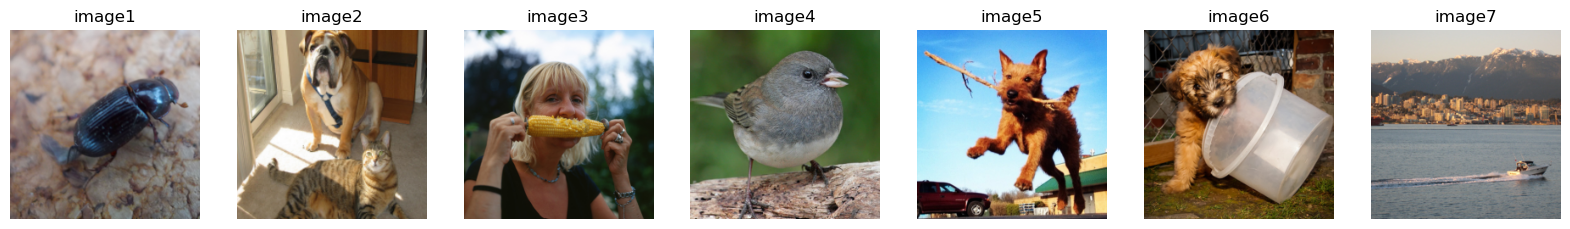

In [5]:
# Let's visualize the images
f, axarr = plt.subplots(1, 7, figsize=(20, 10))
for i in range(len(images)):
    axarr[i].imshow(np.moveaxis(images[i].numpy(), 0, -1))
    axarr[i].axis('off')
    axarr[i].set_title(f'image{i+1}')

Before you continue with the rest of the task, pause a moment and think about how you would label each image with one object name (e.g. tree).

----

The next cell defines our explain method using variations of Integrated Gradients. You have already met the *layer* variant in Task 1. In this task, we will now compare that variant to the standard one: Does it make a difference whether we apply the technique to the whole network (i.e., [**IntegratedGradients (IG)**](https://captum.ai/api/integrated_gradients.html)) or just a part of it (i.e.  [**LayerIntegratedGradients (LIG)**](https://captum.ai/api/layer.html#layer-integrated-gradients))? Why do we even bother to analyze both when for Task 1, the LIG variant was sufficient? The reason for this is that our modality in Task 2 (image) is fundamentally different from the modality in Task 1 (text), and so are the functionalities of our models. For instance, in this CNN model, our first layer does not perform a linear translation into an encoded representation of our input as it was the case for the embeddings in Task 1, but actually reduces groups of input pixels to some shared meaning. In other words, we perform a feature extraction within the model. In fact, almost all layers in an image classification CNN can be seen as feature extraction, reduction and processing layers, and only the final layers are actually responsible for the classification. Therefore, explanation methods in such models are often applied only to the last layer, expecting that it would tell us most about why certain groups of pixels are more important for the distinction between "house" and "castle", for example. But are we not simplifying this too much now? Should we not look at the whole network and regard the feature extraction layers as equally relevant for the final decision? For a better understanding, we will try both in this task. 

We can choose between using IG or LIG via the parameter *layer_specific*. If *layer_specific=True*, we will use LIG, otherwise the normal IG. The exact layer that we are computing the gradients for in the former case can be controlled via *layer*. 

One option to increase the expressiveness of our explanations is to use a [**NoiseTunnel**](https://captum.ai/api/noise_tunnel.html). This means that we run our attribution operation several (*nt_samples*) times on the same input but each time we add Gaussian noise to the input to get a slightly different version of it. The attribution maps we get after each time are finally combined to one heatmap for the input image. The method *how* we combine them is controlled via *nt_type*: we can either compute the mean of the attribution maps (*smoothgrad*), the mean of the squared attribution maps (*smoothgrad_sq*), or the variance of the attribution mas (*vargrad*). Whether to use a noise tunnel or not is controlled via the *noise_tunnel* parameter.

We will also use one parameter *labels* for selecting the label that we want to have the explanations for. This means that we do not have to compute the explanation for the actual predicted class of an image but can use in fact any of the 1000 ImageNet classes. That can be helpful to analyze where the model would focus on to decide for a different, but also possible class. For now, we will not care about this, set *labels=None*, and create the explanations for the actual predicted classes of the model.

The explanations will be visualized as row of three images each: the original image, the heatmap, and a fusion of original image and heatmap. 

In [20]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
                                                 N=256)


def explain_images(images, labels=None, layer_specific=False, noise_tunnel=False, layer=model.layer4[-1]):
    if layer_specific:
        explainer = LayerIntegratedGradients(model, layer)
        print('Explain images with Layer Integrated Gradients')
    else:
        explainer = IntegratedGradients(model)
        print('Explain images with Integrated Gradients')
        
    attribute_params = {'n_steps': 200}
        
    if noise_tunnel:
        explainer = NoiseTunnel(explainer)
        attribute_params.update({'nt_samples': 2, 'nt_type': 'smoothgrad'})
        print('Use Noise Tunnel to increase expressiveness')


    for i in range(len(images)):
        img = images[i]
        x = img.unsqueeze(0)
        normalized_x = normalize_transform(x)
        
        output = F.softmax(model(normalized_x), dim=1).squeeze()
        pred_score, pred_label_idx = torch.topk(output, 1)

        target = labels[i] if labels and labels[i] else pred_label_idx.item()
        
        target_list = target if isinstance(target, list) else [target]
        
        for t in target_list:
            attributions = explainer.attribute(normalized_x, target=t, **attribute_params)

            # We need to scale the attribution to the input shape if the explanation was produced for a layer with
            # less nodes than our input image
            if attributions.shape[-1] != 224:
                attributions = LayerAttribution.interpolate(attributions, (224, 224), 'bicubic')

            _ = visualization.visualize_image_attr_multiple(
                                     np.transpose(attributions.squeeze(0).detach().numpy(), (1,2,0)),
                                     np.transpose(x.squeeze().detach().numpy(), (1,2,0)),
                                     methods=["original_image", "heat_map", "blended_heat_map"],
                                     cmap=default_cmap,
                                     show_colorbar=True,
                                     signs=["all", "positive", "positive"])

            print(f'Predicted label: {idx2label[pred_label_idx.item()]}, score: {pred_score.item()}, '
                  f'heat map for label: {idx2label[t]}')
        print('-'*100)

Let's run Integrated Gradients to explain our model:

Explain images with Integrated Gradients


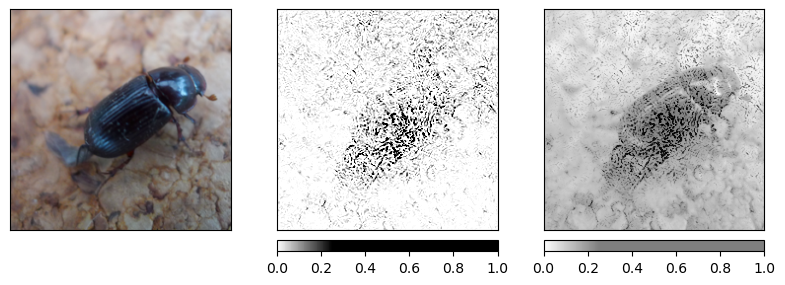

Predicted label: dung_beetle, score: 0.7941450476646423, heat map for label: dung_beetle
----------------------------------------------------------------------------------------------------


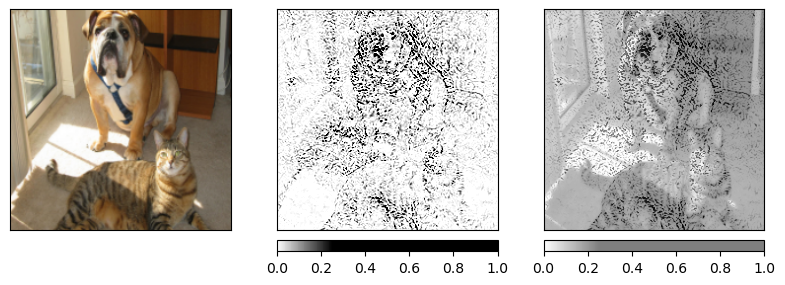

Predicted label: boxer, score: 0.41621828079223633, heat map for label: boxer
----------------------------------------------------------------------------------------------------


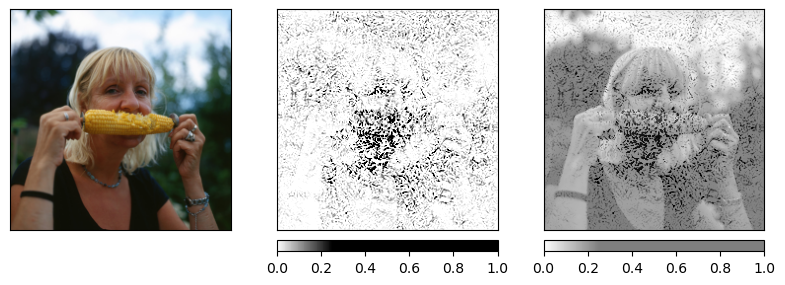

Predicted label: ear, score: 0.9232572317123413, heat map for label: ear
----------------------------------------------------------------------------------------------------


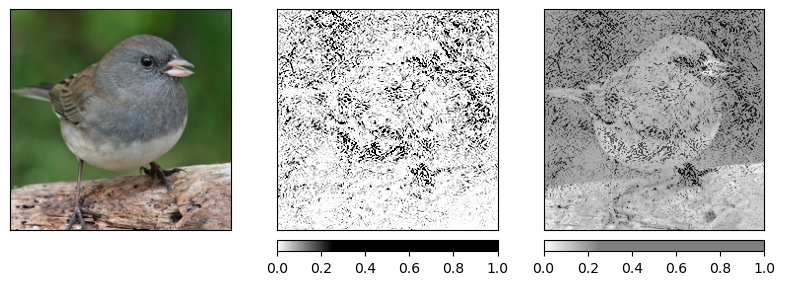

Predicted label: junco, score: 0.9995864033699036, heat map for label: junco
----------------------------------------------------------------------------------------------------


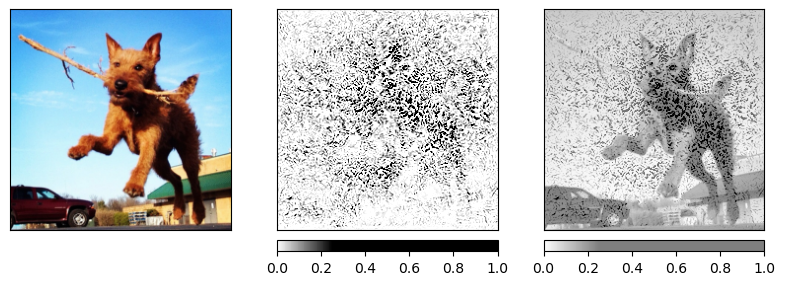

Predicted label: Irish_terrier, score: 0.9172899127006531, heat map for label: Irish_terrier
----------------------------------------------------------------------------------------------------


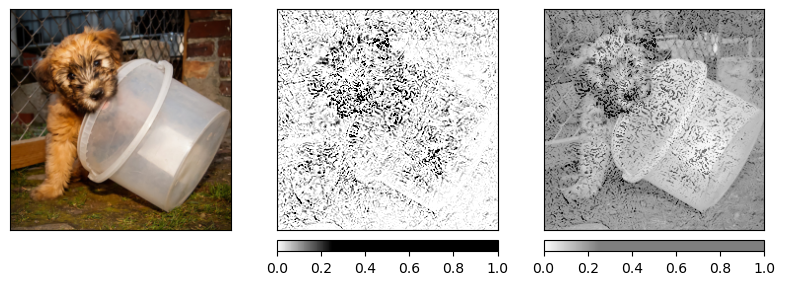

Predicted label: soft-coated_wheaten_terrier, score: 0.7839930653572083, heat map for label: soft-coated_wheaten_terrier
----------------------------------------------------------------------------------------------------


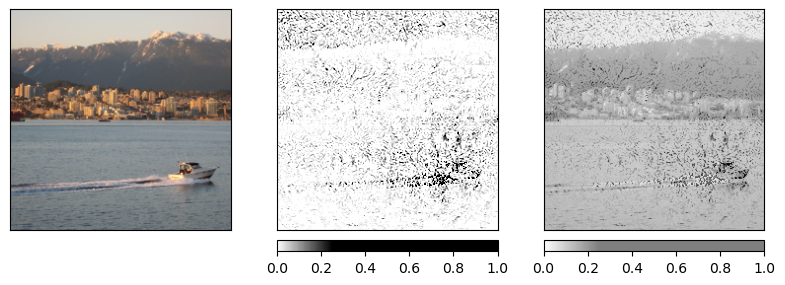

Predicted label: speedboat, score: 0.386803537607193, heat map for label: speedboat
----------------------------------------------------------------------------------------------------


In [15]:
explain_images(images, layer_specific=False)

And Layer Integrated Gradients:

Explain images with Layer Integrated Gradients


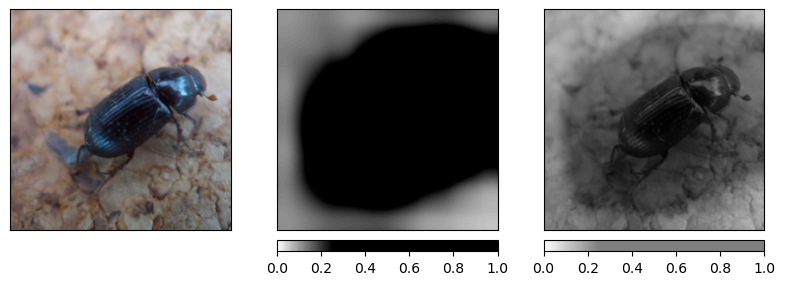

Predicted label: dung_beetle, score: 0.7941450476646423, heat map for label: dung_beetle
----------------------------------------------------------------------------------------------------


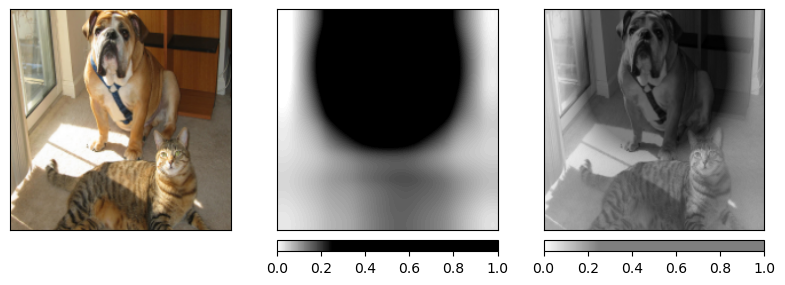

Predicted label: boxer, score: 0.41621828079223633, heat map for label: boxer
----------------------------------------------------------------------------------------------------


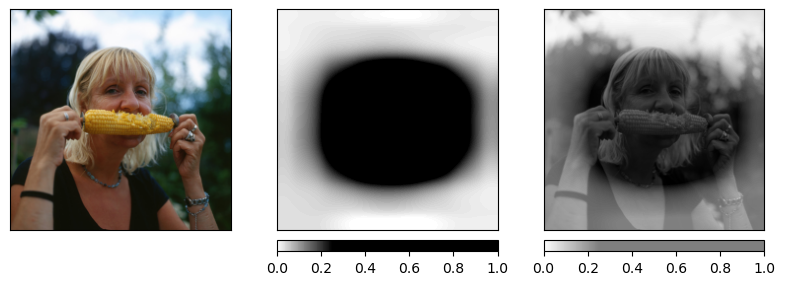

Predicted label: ear, score: 0.9232572317123413, heat map for label: ear
----------------------------------------------------------------------------------------------------


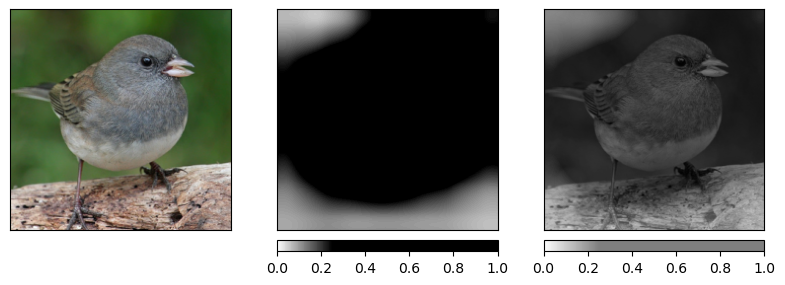

Predicted label: junco, score: 0.9995864033699036, heat map for label: junco
----------------------------------------------------------------------------------------------------


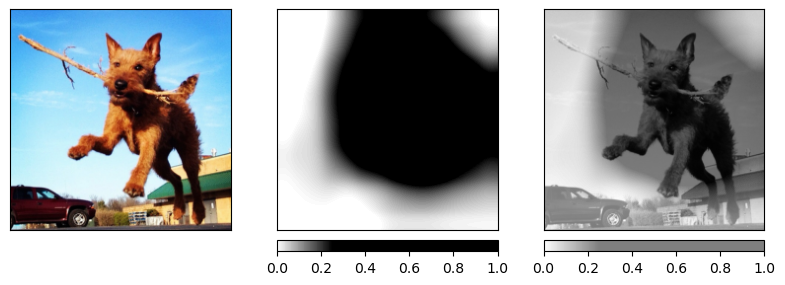

Predicted label: Irish_terrier, score: 0.9172899127006531, heat map for label: Irish_terrier
----------------------------------------------------------------------------------------------------


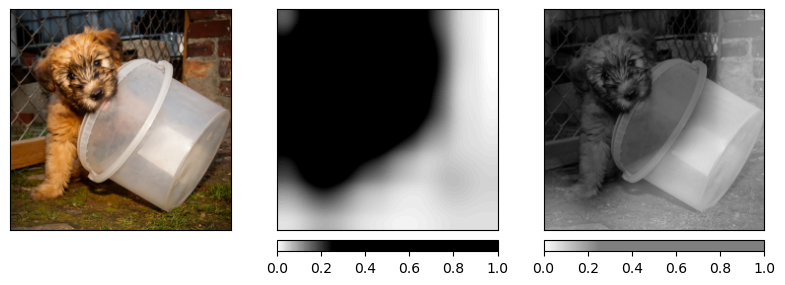

Predicted label: soft-coated_wheaten_terrier, score: 0.7839930653572083, heat map for label: soft-coated_wheaten_terrier
----------------------------------------------------------------------------------------------------


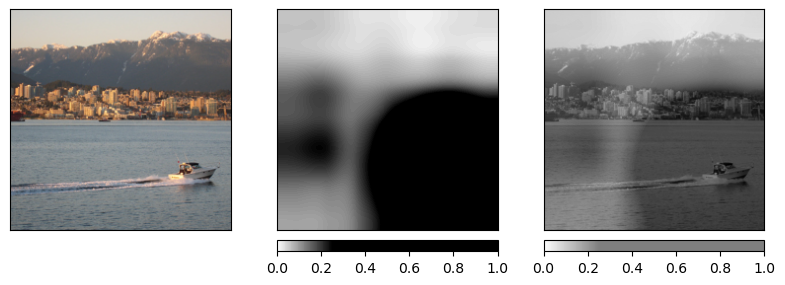

Predicted label: speedboat, score: 0.386803537607193, heat map for label: speedboat
----------------------------------------------------------------------------------------------------


In [8]:
explain_images(images, layer_specific=True)

Explain images with Integrated Gradients
Use Noise Tunnel to increase expressiveness


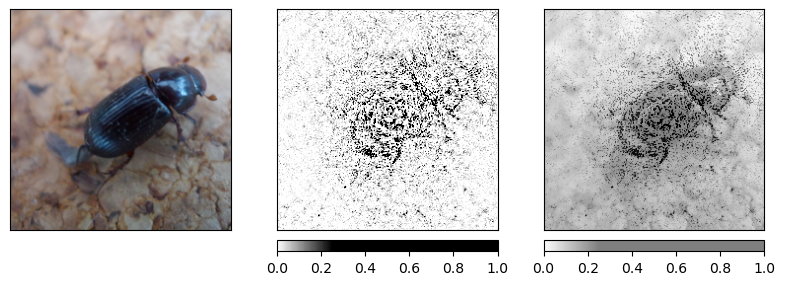

Predicted label: dung_beetle, score: 0.7941450476646423, heat map for label: dung_beetle
----------------------------------------------------------------------------------------------------


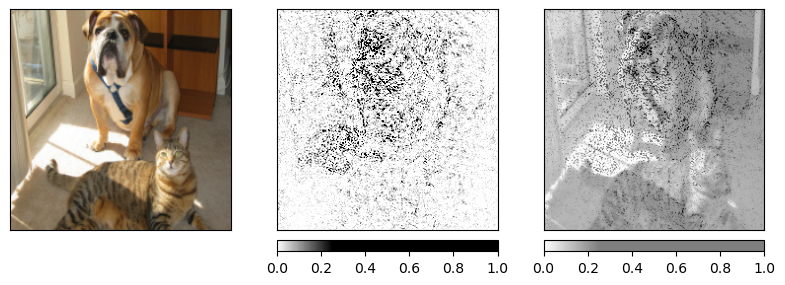

Predicted label: boxer, score: 0.41621828079223633, heat map for label: boxer
----------------------------------------------------------------------------------------------------


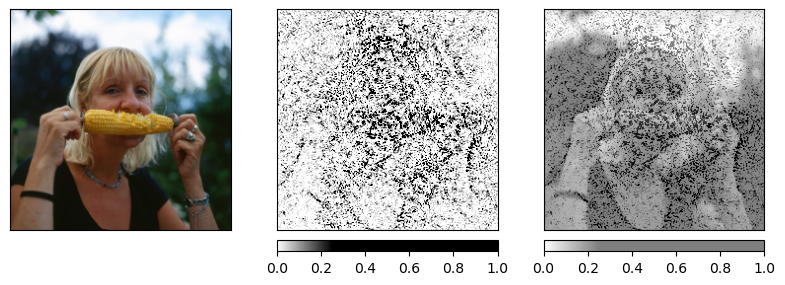

Predicted label: ear, score: 0.9232572317123413, heat map for label: ear
----------------------------------------------------------------------------------------------------


In [18]:
explain_images(images[:3], labels=None, layer_specific=False, noise_tunnel=True)

Explain images with Layer Integrated Gradients
Use Noise Tunnel to increase expressiveness


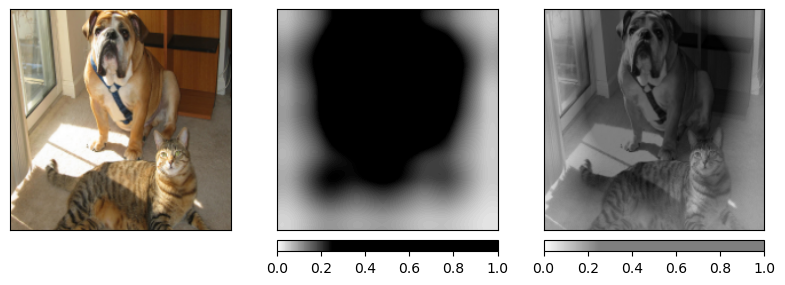

Predicted label: boxer, score: 0.41621828079223633, heat map for label: boxer
----------------------------------------------------------------------------------------------------


In [15]:
explain_images(images[1:2], layer_specific=True, noise_tunnel=True)

In [18]:
# Find label id
labels = ['dog', 'cat', 'corn', 'soft-coated_wheaten_terrier', 'bucket']
for label in labels:
    for id, l in idx2label.items():
        if l == label:
            print(id, l)

987 corn
202 soft-coated_wheaten_terrier
463 bucket


Explain images with Layer Integrated Gradients


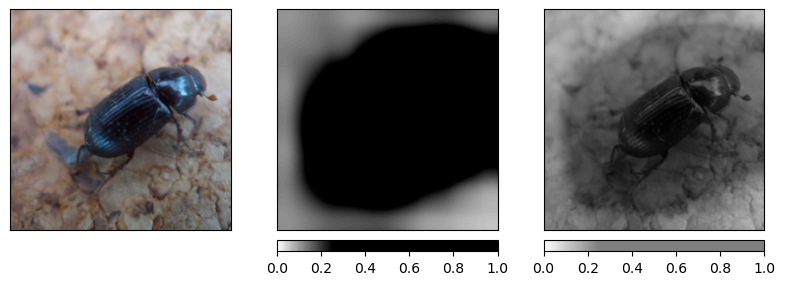

Predicted label: dung_beetle, score: 0.7941450476646423, heat map for label: dung_beetle
----------------------------------------------------------------------------------------------------


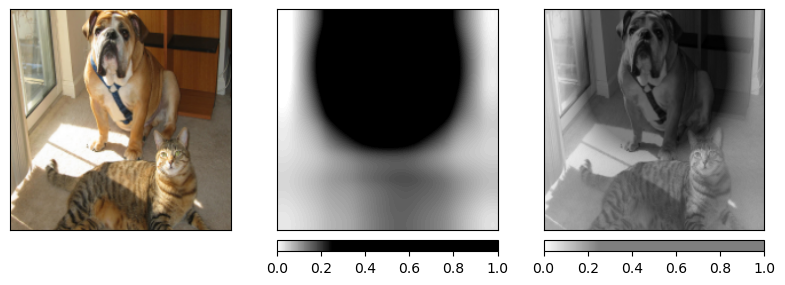

Predicted label: boxer, score: 0.41621828079223633, heat map for label: boxer
----------------------------------------------------------------------------------------------------


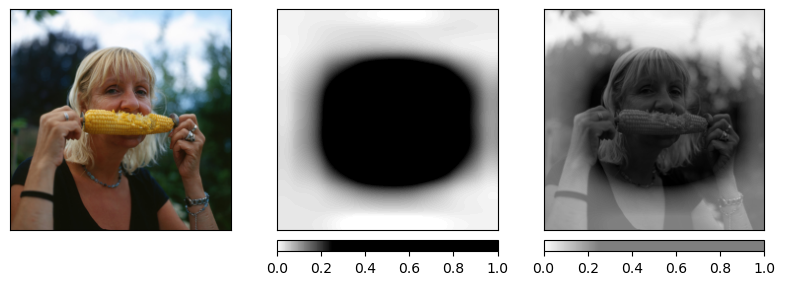

Predicted label: ear, score: 0.9232572317123413, heat map for label: corn
----------------------------------------------------------------------------------------------------


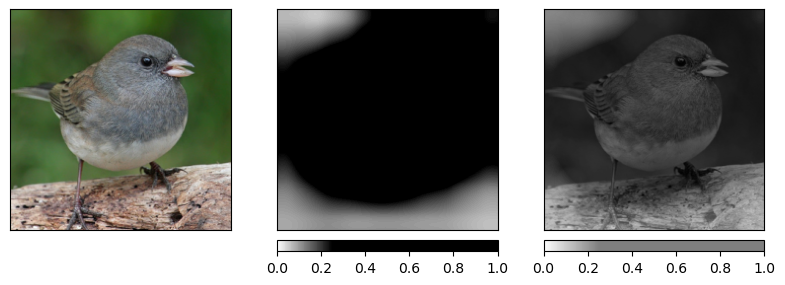

Predicted label: junco, score: 0.9995864033699036, heat map for label: junco
----------------------------------------------------------------------------------------------------


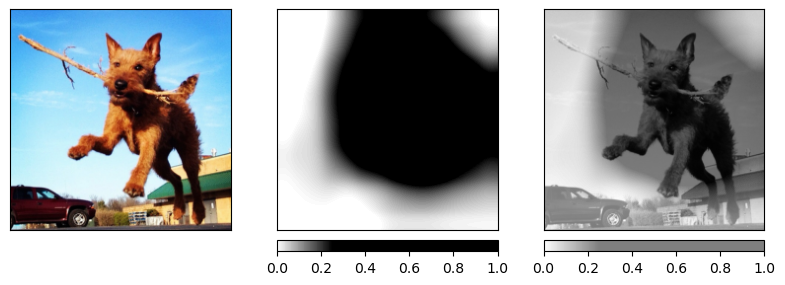

Predicted label: Irish_terrier, score: 0.9172899127006531, heat map for label: Irish_terrier
----------------------------------------------------------------------------------------------------


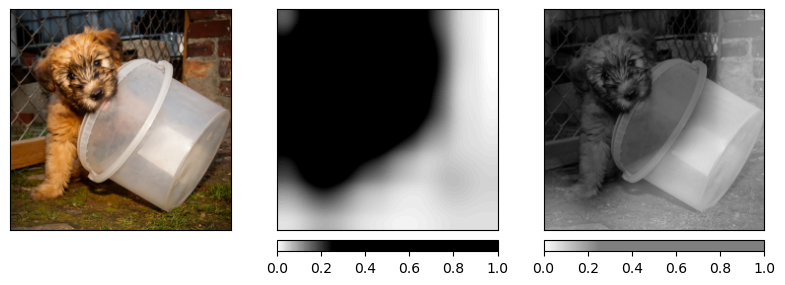

Predicted label: soft-coated_wheaten_terrier, score: 0.7839930653572083, heat map for label: soft-coated_wheaten_terrier


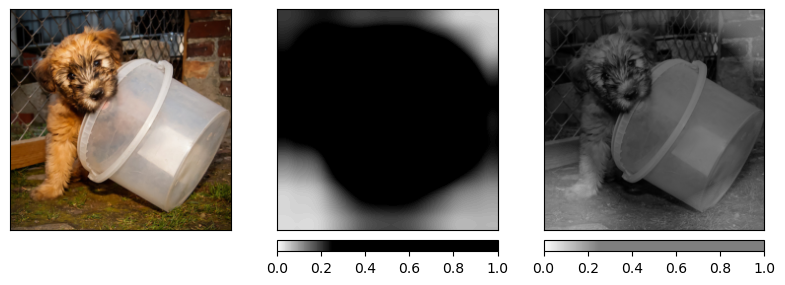

Predicted label: soft-coated_wheaten_terrier, score: 0.7839930653572083, heat map for label: bucket
----------------------------------------------------------------------------------------------------


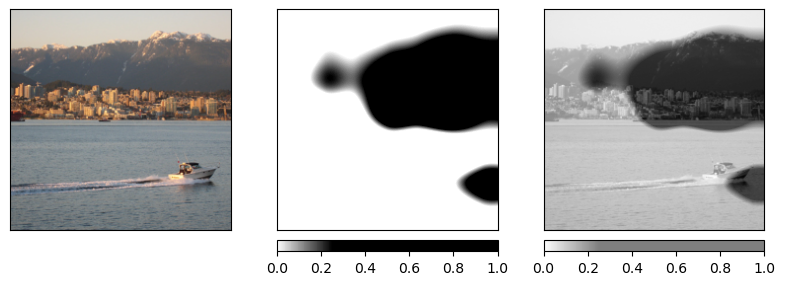

Predicted label: speedboat, score: 0.386803537607193, heat map for label: goldfish
----------------------------------------------------------------------------------------------------


In [22]:
explain_images(images, labels=[None, None, 987, None, None, [202, 463], 1], layer_specific=True)

### Questions:

##### 1) Classification labels
Look at each image and think about how you would classify it with one term (corresponding to the main object in the image). Then compare that with the prediction of the model. Do you agree in each case?

##### 2) Explanations to classification labels
For each image, check the heatmaps that are visualized as explanation (separately or laid over the image). How well do the heatmaps correspond to what you would have expected? How well to the predictions?

##### 3) Noise tunnel
Set noise tunnel to true. Select 3 images and run the explainers for them. How does the noise tunnel influence the explanations? Explain why.

##### 4) Hyperparameters for LIG and IG
Besides the **n_steps** hyperparameter of (layer) integrated gradients that you already encountered in Task 1, the noise tunnel now introduces two additional hyperparameters: **nt_samples** (how many noisy examples to create for one input) and **nt_type** (smoothing method for the attributions). 

Select one image and try different settings for the three hyperparameters. What do you find out? What seems to be the best setting? Explain why.

*Note: Some hyperparameters have a big effect on runtime and memory usage. It can happen that the notebook crashes if the values are too high. Therefore, we do not expect you to try nt_steps above 500 or nt_samples above 10 in this exercise.*

##### 5) Explanations for different possible labels
Some images contain several objects that could have been predicted by the model instead of the label it actually outputs. Example: image 6 could be the dog or the bucket. For these images, pick a label for each of such objects from the *idx2label* mapping (if there is a label), and input the index of that label to the *label* parameter of *explain_images*. 

The parameter should be a list in which each position corresponds to one of the seven images, indicating the label(s) that should be used for calculating the attribution. If you give several labels for one image (as nested list), the image will be processed several times. If you want to use the predicted label for one image instead of a manually selected one, input *None*. Example: [None, [0, 12], 13, None, [6, 7, 9], None, 26]. How do the heatmap explanations change? Do they make sense?

##### 6) Explanations for nonsensical labels
What happens if you input labels that do not make sense for a specific image; e.g. 'orangutan' for image 1? Explain why.

##### 7) Discussion
Analogous to Task 1: Do you think the heatmaps are actually *explaining the model*? 

### Answers:

#### 1)
The labels I would give to each image are: 

1. beetle
2. dog
3. woman
4. bird
5. dog
6. dog
7. boat

Compared to the labels predicted by the model, I only disagree with the 3rd one, where the model labels the image as "ear". However, it is interesting to note that the model's predictions could be more accurate than a human's in terms of using specific terms for species.

#### 2)
The heatmaps from Integrated Gradients work as I expected, whereas the heatmaps from Layer Integrated Gradients look a little bit simplistic to me, as they mark out a relatively large region around the object. In terms of prediction, some heatmaps from Integrated Gradients are difficult to interpret in terms of identifying the objects (e.g., the one for the beetle and the one for the woman). On the other hand, the heatmaps from Layer Integrated Gradients only show a black region, which makes it challenging to convince people that the model made those accurate predictions based on those dark regions.

#### 3)
The heatmaps generated by Integrated Gradients with a noise tunnel have a stronger focus on the objects and their features. For example, in the image of the dung beetle, there are more dots concentrated within the shape of the beetle, a clear line on its body, and increased emphasis on its legs. The noise tunnel enhances the robustness of the heatmap to noise and enables a focus on the most important features. Additionally, by combining the heatmaps from different iterations, the final heatmap can capture the most influential parts and identify which areas are less important.

#### 4)
* IG
    - nt_type: smoothgrad
    - n_steps: 300
    - nt_samples: 6

When using larger value (e.g., 6) for nt_samples but not large enough step (in my case it was only 150 steps), the generated heatmap focuses on some noise.

* LIG
    - nt_type: smoothgrad_sq
    - n_steps: 150
    - nt_samples: 3

There are two objects (dog and cat) in the image, and it is more likely to generate heatmap focus on one area rather than two area by using smoothgrad_sq.

#### 5)
When changing the label for image 3 from "ear" to "corn", the heatmap does not change. However, when changing the label for image 6 to "soft-coated_wheaten_terrier" and "bucket", the two heatmaps focus on the respective objects correctly.

#### 6)
When changing the label for image 7 from "speedboat" to "goldfish", the generated heatmap does not provide a meaningful explanation. The explanation method assumes it should explain for "goldfish", so it may try to pick up features that look similar to features for goldfish on the image.

#### 7)
The heatmap provides us with an intuition and a better understanding of which features or regions in the image the model values more when making predictions. However, it is important to note that how the model is explained does not necessarily reflect its actual behavior.
